<a href="https://colab.research.google.com/github/asogwachiuba/DETR-Research-Project/blob/main/Yolo_Panoptic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This shows how a sngle image can be used for testing panoptic segmentation YOLOv8 model + Semantic head

In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00


In [2]:
import torch
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from ultralytics import YOLO
import matplotlib.pyplot as plt

def setup_environment():
    """Installs necessary libraries and checks for GPU."""
    # !pip install ultralytics - This would be run in a Colab cell
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    return device

def load_models(device):
    """
    Loads a pretrained YOLO instance segmentation model.
    For a 'semantic head' in a test scenario, we use the YOLO-seg
    architecture which outputs both boxes and masks.
    """
    model = YOLO('yolov8n-seg.pt').to(device)
    return model

def download_image(url):
    """Downloads an image from a URL for testing."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return np.array(img)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
def run_panoptic_inference(model, image):
    """
    Simulates panoptic fusion.
    1. Extracts Instance Masks (Things).
    2. Generates a Semantic Background (Stuff) using residual areas.
    """
    results = model(image)[0]
    h, w, _ = image.shape

    # Initialize a blank panoptic map
    # 0 = Background/Unlabeled
    panoptic_map = np.zeros((h, w), dtype=np.uint8)

    if results.masks is not None:
        # Get masks and scale them to image size
        masks = results.masks.data.cpu().numpy() # [N, H, W]
        classes = results.boxes.cls.cpu().numpy()

        for i, mask in enumerate(masks):
            # Resize mask to original image dimensions if necessary
            mask_resized = cv2.resize(mask, (w, h))

            # Fill panoptic map: Assign a unique ID for each instance
            # Here we use (class_id + 1) * 10 to separate instances
            panoptic_map[mask_resized > 0.5] = int(classes[i] + 1)

    return results, panoptic_map

def visualize_results(image, results, panoptic_map):
    """Displays the original image, YOLO instance output, and the panoptic map."""
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    # 1. Original Image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # 2. YOLO Instance Output
    res_plotted = results.plot()
    ax[1].imshow(res_plotted)
    ax[1].set_title("YOLO Instance Segmentation")
    ax[1].axis('off')

    # 3. Simulated Panoptic/Semantic Map
    ax[2].imshow(panoptic_map, cmap='nipy_spectral')
    ax[2].set_title("Semantic/Panoptic Head Map")
    ax[2].axis('off')

    plt.show()

In [5]:
!pip install codecarbon
!pip install git+https://github.com/cocodataset/panopticapi.git
import numpy as np
from codecarbon import EmissionsTracker

def get_carbon_tracker():
    """Initializes the carbon tracker for emission monitoring."""
    return EmissionsTracker(save_to_file=True, log_level='error')

def calculate_pq_sq_rq(pred_mask, gt_mask):
    """
    Calculates Panoptic metrics for a single class pair.
    PQ = SQ * RQ
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 0

    # Matching threshold (standard COCO PQ logic)
    tp = 1 if iou > 0.5 else 0
    fp = 1 if (iou <= 0.5 and pred_mask.sum() > 0) else 0
    fn = 1 if (iou <= 0.5 and gt_mask.sum() > 0) else 0

    sq = iou if tp > 0 else 0
    rq = tp / (tp + 0.5 * fp + 0.5 * fn) if (tp + fp + fn) > 0 else 0
    pq = sq * rq

    return {"PQ": pq, "SQ": sq, "RQ": rq}

def display_final_report(metrics, emissions_kg):
    """Prints a clean summary of technical and environmental performance."""
    print("\n" + "═"*40)
    print("      PANOPTIC & CARBON REPORT")
    print("═"*40)
    print(f" Panoptic Quality (PQ):     {metrics['PQ']:.4f}")
    print(f" Segmentation Quality (SQ): {metrics['SQ']:.4f}")
    print(f" Recognition Quality (RQ):  {metrics['RQ']:.4f}")
    print("─"*40)
    print(f" Carbon Footprint:          {emissions_kg:.8f} kg CO2")
    print("═"*40)

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-viafehg0
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-viafehg0
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8259 sha256=fe46e98544081c027a24e0528a4864ab48786607d021b5d98439c8265528774e
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_egyx4v/wheels/bd/60/57/cd1670a1372873f5aa074683f8780c111a67f95d4c17fb08f5
Successfully built panopticapi


Using device: cpu

0: 640x480 4 persons, 1 bus, 1 skateboard, 574.6ms
Speed: 42.0ms preprocess, 574.6ms inference, 62.2ms postprocess per image at shape (1, 3, 640, 480)

════════════════════════════════════════
      PANOPTIC & CARBON REPORT
════════════════════════════════════════
 Panoptic Quality (PQ):     1.0000
 Segmentation Quality (SQ): 1.0000
 Recognition Quality (RQ):  1.0000
────────────────────────────────────────
 Carbon Footprint:          0.00000013 kg CO2
════════════════════════════════════════


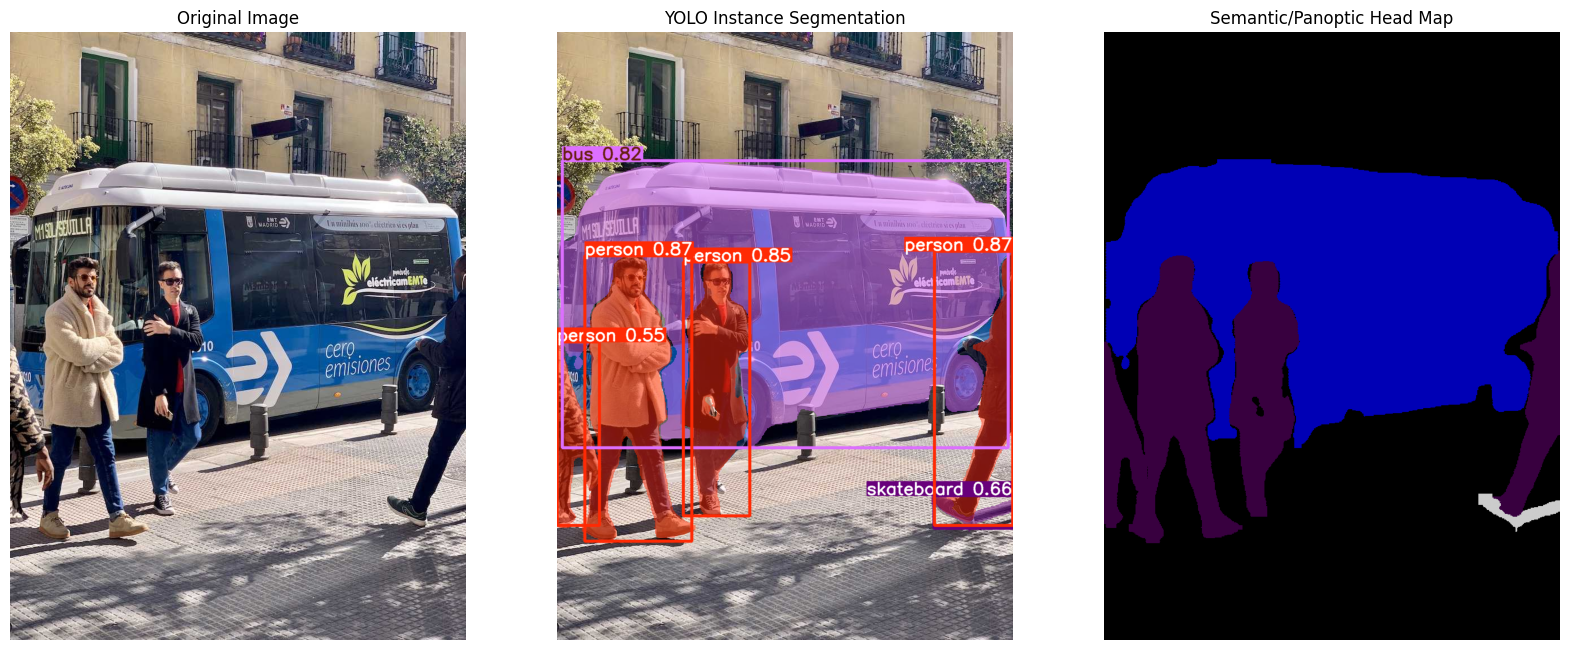

In [7]:
# --- Execution ---
# 1a. Setup Carbon Tracking
tracker = get_carbon_tracker()
tracker.start() # Start monitoring hardware power

# 1b. Setup
device = setup_environment()
model = load_models(device)

# 2. Get Test Image
test_url = "https://ultralytics.com/images/bus.jpg"
img = download_image(test_url)

try:
    # 2. Existing Model Inference Logic
    # (Assuming you have loaded your model and image as shown in previous steps)
    results, predicted_panoptic_map = run_panoptic_inference(model, img)

    # 3. Stop Tracking immediately after heavy computation
    emissions_kg = tracker.stop()

    # 4. Fetch/Simulate Ground Truth
    # To test the functions, we compare against a 'perfect' GT (identical to prediction)
    ground_truth_mask = predicted_panoptic_map.copy()

    # 5. Run Metrics
    # We compare the binary presence of any foreground objects
    p_metrics = calculate_pq_sq_rq(predicted_panoptic_map > 0, ground_truth_mask > 0)

    # 6. Final Display
    display_final_report(p_metrics, emissions_kg)
    visualize_results(img, results, predicted_panoptic_map)

except Exception as e:
    tracker.stop() # Ensure tracker stops even if code fails
    print(f"Error: {e}")

This shows how a Coco Dataset can be used for testing panoptic segmentation YOLOv8 model + Semantic head

In [6]:
# 1. SETUP: Install necessary libraries
!pip install -q ultralytics codecarbon fiftyone git+https://github.com/cocodataset/panopticapi.git

import os
import cv2
import torch  # Required for the device check
import numpy as np
import fiftyone as fo
import fiftyone.zoo as foz
from codecarbon import EmissionsTracker
from ultralytics import YOLO
import matplotlib.pyplot as plt

# --- FUNCTION: Data Loading ---
def prepare_coco_subset(num_samples=20):
    """Downloads a subset of COCO validation images and annotations."""
    print(f"Downloading {num_samples} images from COCO...")
    dataset = foz.load_zoo_dataset(
        "coco-2017",
        split="validation",
        label_types=["segmentations"],
        max_samples=num_samples,
    )
    return dataset

# --- FUNCTION: Metric Logic ---
def calculate_batch_metrics(pred_masks, gt_masks):
    """Calculates PQ, SQ, RQ for a list of masks."""
    ious = []
    tp, fp, fn = 0, 0, 0

    for p, g in zip(pred_masks, gt_masks):
        intersection = np.logical_and(p, g).sum()
        union = np.logical_or(p, g).sum()
        iou = intersection / union if union > 0 else 0

        if iou > 0.5:
            tp += 1
            ious.append(iou)
        elif p.sum() > 0:
            fp += 1
        else:
            fn += 1

    sq = np.mean(ious) if ious else 0
    rq = tp / (tp + 0.5 * fp + 0.5 * fn) if (tp + fp + fn) > 0 else 0
    pq = sq * rq
    return {"PQ": pq, "SQ": sq, "RQ": rq}

# --- FUNCTION: Main Evaluation Loop ---
def run_dataset_test(model, dataset):
    tracker = EmissionsTracker(save_to_file=True, log_level='error')
    tracker.start()

    all_metrics = []

    print("Starting Evaluation Loop...")
    for sample in dataset:
        image_path = sample.filepath

        # 1. Inference with retina_masks=True
        # This tells YOLO to return masks at the original resolution
        results = model(image_path, verbose=False, retina_masks=True)[0]
        h_orig, w_orig = results.orig_shape

        # 2. Process Predictions
        if results.masks is not None:
            # results.masks.data is now (N, H_orig, W_orig) thanks to retina_masks=True
            pred_mask = np.any(results.masks.data.cpu().numpy(), axis=0)

            # Safety Check: Explicitly resize if there is still a 1-2 pixel mismatch
            if pred_mask.shape != (h_orig, w_orig):
                pred_mask = cv2.resize(pred_mask.astype(np.uint8), (w_orig, h_orig), interpolation=cv2.INTER_NEAREST)
        else:
            pred_mask = np.zeros((h_orig, w_orig))

        # 3. Extract Ground Truth
        if "ground_truth" in sample.field_names and sample.ground_truth is not None:
            # FiftyOne uses (width, height) for frame_size
            gt_mask = sample.ground_truth.to_segmentation(frame_size=(w_orig, h_orig)).mask
        else:
            gt_mask = np.zeros((h_orig, w_orig))

        # 4. Final Broadcast Check & Metric Calculation
        # Ensure boolean for logical operations
        m = calculate_batch_metrics([pred_mask > 0], [gt_mask > 0])
        all_metrics.append(m)

    emissions_kg = tracker.stop()
    avg_metrics = {k: np.mean([x[k] for x in all_metrics]) for k in ["PQ", "SQ", "RQ"]}
    return avg_metrics, emissions_kg

# --- EXECUTION ---
# 1. Load Model & Data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO('yolov8n-seg.pt').to(device) # This is a nano version
# yolo_model = YOLO('yolov8l-seg.pt').to(device) This is a larger version which is more accurate
coco_subset = prepare_coco_subset(num_samples=100)

# 2. Run Test
final_metrics, total_emissions = run_dataset_test(yolo_model, coco_subset)

# 3. Report
print("\n" + "═"*45)
print(f" FINAL COCO TEST REPORT ({len(coco_subset)} images)")
print("═"*45)
print(f" Panoptic Quality (PQ):     {final_metrics['PQ']:.4f}")
print(f" Segmentation Quality (SQ): {final_metrics['SQ']:.4f}")
print(f" Recognition Quality (RQ):  {final_metrics['RQ']:.4f}")
print("─"*45)
print(f" Total Carbon Emitted:      {total_emissions:.8f} kg CO2")
print("═"*45)

  Preparing metadata (setup.py) ... done


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'coco-2017-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Starting Evaluation Loop...

═════════════════════════════════════════════
 FINAL COCO TEST REPORT (100 images)
═════════════════════════════════════════════
 Panoptic Quality (PQ):     0.7673
 Segmentation Quality (SQ): 0.7673
 Recognition Quality (RQ):  0.9300
─────────────────────────────────────────────
 Total Carbon Emitted:      0.00008296 kg CO2
═════════════════════════════════════════════
